In [2]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import geopandas as gpd 

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# Trade Area Analysis

### Opening Rate and Closing Rate Data Analysis 
- 발달상권
- 골목상권
- 전통시장

In [18]:
from __future__ import annotations
import os
import re
from pathlib import Path
from typing import Dict, Iterable, Mapping, Optional
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


class OCRPipeline:
    """
    Pipeline for loading '개폐업수(율)' Excel files, filtering between two city rows by index,
    selecting a target city, extracting '개업수' for a given quarter per year, and plotting.

    - Robust to '률/율' spelling.
    - Handles per-year quarter exceptions (e.g., 2025: '2분기', others: '4분기' by default).
    """

    def __init__(
        self,
        ocr_path: str | Path,
        years: Iterable[int],
        quarter_by_year: Optional[Mapping[int, str]] = None,
        default_quarter: str = "4분기",
        start_city: str = "고양시",
        end_city: str = "과천시",
        admin_col: str = "행정구역",
    ):
        self.ocr_path = Path(ocr_path)
        self.years = list(years)
        self.qmap = dict(quarter_by_year or {})
        self.default_quarter = default_quarter
        self.start_city = start_city
        self.end_city = end_city
        self.admin_col = admin_col

        self.raw: Dict[int, pd.DataFrame] = {}
        self.filtered_range: Dict[int, pd.DataFrame] = {}
        self.city_only: Dict[int, pd.DataFrame] = {}
        self.timeseries: Optional[pd.DataFrame] = None

    def _quarter(self, year: int) -> str:
        return self.qmap.get(year, self.default_quarter)

    def _filename(self, year: int) -> str:
        # Ex: 개폐업수(율)(2021_4분기_전분기_발달상권_업종전체_상권별현황).xlsx
        return f"개폐업수(율)({year}_{self._quarter(year)}_전분기_발달상권_업종전체_상권별현황).xlsx"

    def load(self) -> "OCRPipeline":
        for y in self.years:
            fp = self.ocr_path / self._filename(y)
            if not fp.exists():
                raise FileNotFoundError(f"Missing file for {y}: {fp}")
            self.raw[y] = pd.read_excel(fp)
        return self

    def filter_between_cities(self) -> "OCRPipeline":
        """
        Slice from start_city (inclusive) to end_city (exclusive) by index.
        Assumes exactly one row each for the city labels in admin_col.
        """
        out = {}
        for y, df in self.raw.items():
            try:
                sidx = df[df[self.admin_col] == self.start_city].index[0]
                eidx = df[df[self.admin_col] == self.end_city].index[0]
            except IndexError as e:
                raise ValueError(
                    f"{y}: Could not find '{self.start_city}' or '{self.end_city}' in column '{self.admin_col}'."
                ) from e

            if sidx >= eidx:
                raise ValueError(
                    f"{y}: start index ({sidx}) is not before end index ({eidx}). "
                    f"Check the order of rows for '{self.start_city}' and '{self.end_city}'."
                )

            out[y] = df.iloc[sidx:eidx].copy()
        self.filtered_range = out
        return self

    def select_city(self, city: str = "고양시") -> "OCRPipeline":
        city_dfs = {}
        for y, df in self.filtered_range.items():
            sub = df[df[self.admin_col] == city].copy()
            if sub.empty:
                raise ValueError(f"{y}: Target city '{city}' not found after range filtering.")
            city_dfs[y] = sub
        self.city_only = city_dfs
        return self

    @staticmethod
    def _match_column(df: pd.DataFrame, pattern: str) -> str:
        """Return the first column name that fully matches the regex pattern."""
        cols = [c for c in df.columns if re.fullmatch(pattern, str(c))]
        if not cols:
            raise KeyError(f"No column matches regex: /{pattern}/. Available: {list(df.columns)[:8]} ...")
        return cols[0]

    def build_open_count_timeseries(self) -> "OCRPipeline":
        """
        Build a tidy DataFrame with index=year and a single column '개업수',
        pulling '{year}년{quarter} 개업수' for each year (quarter depends on qmap/default).
        Tolerates spaces like '...년{quarter}   개업수'.
        """
        series = []
        for y, df in self.city_only.items():
            q = self._quarter(y)
            # Regex for column like "2021년2분기 개업수" (allowing optional spaces)
            pat_open_cnt = rf"^{y}년\s*{q}\s*개업수$"
            col = self._match_column(df, pat_open_cnt)

            # Expect exactly one row per city at this point
            val = df[col].iloc[0]
            series.append((y, val))

        self.timeseries = pd.DataFrame(series, columns=["year", "개업수"]).set_index("year").sort_index()
        return self

    def plot_open_counts(self, title: str = "고양시 연도별 발달상권 개업수 추이") -> "OCRPipeline":
        if self.timeseries is None:
            raise RuntimeError("timeseries not built. Call build_open_count_timeseries() first.")
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=self.timeseries["개업수"], marker='o', legend=False)
        plt.title(f"{title} ({self.years[0]}–{self.years[-1]})", fontsize=20)
        plt.xlabel("년도")
        plt.ylabel("개업수")
        plt.xticks(self.timeseries.index, [str(y) for y in self.timeseries.index])
        plt.tight_layout()
        plt.show()
        return self

    # Convenience: all-in-one
    def run_all(self, city: str = "고양시") -> "OCRPipeline":
        return (
            self.load()
                .filter_between_cities()
                .select_city(city=city)
                .build_open_count_timeseries()
        )


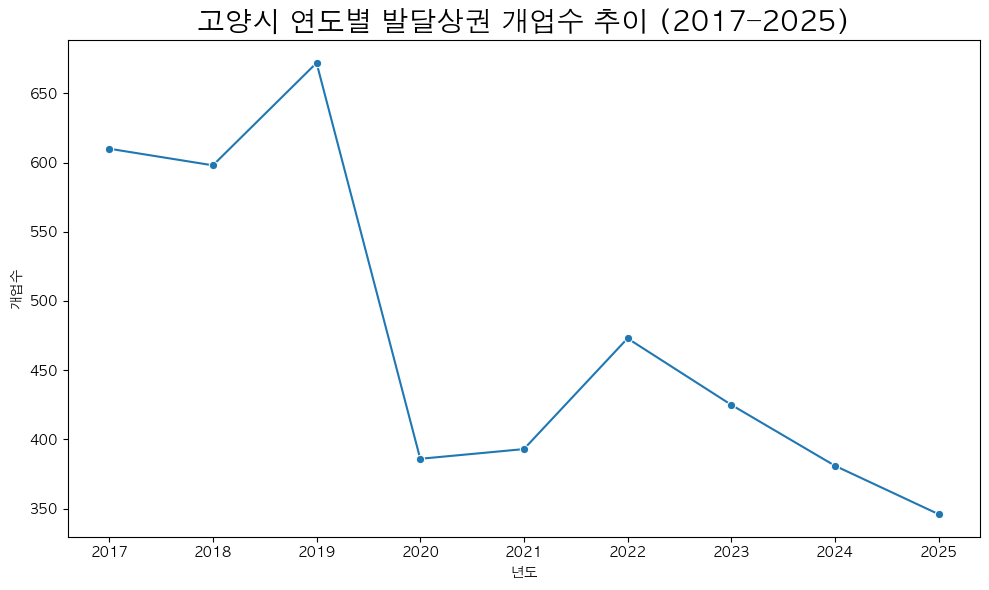

In [19]:
ocr_path = "상권분석/상권별/발달상권/개폐업수(율)/전체업종/"
years = range(2017, 2026)
quarter_by_year = {2025: "2분기"}  # others default to 4분기

pipe = (
    OCRPipeline(
        ocr_path=ocr_path,
        years=years,
        quarter_by_year=quarter_by_year,
        default_quarter="4분기",
        start_city="고양시",
        end_city="과천시",
        admin_col="행정구역",
    )
    .run_all(city="고양시")
)

# Time series table (index = year, column = 개업수)
pipe.timeseries

# Plot
pipe.plot_open_counts("고양시 연도별 발달상권 개업수 추이")


In [21]:
###### 골목상권 

ocr_path = "상권분석/상권별/골목상권/개폐업수(율)/"

years = range(2017, 2026)
quarters = {
    2025: "2분기",  # exception for 2025
}
dfs = {}

for year in years:
    quarter = quarters.get(year, "4분기")
    filename = f"개폐업수(율)({year}_{quarter}_전분기_골목상권_업종전체_상권별현황).xlsx"
    path = os.path.join(ocr_path, filename)
    dfs[f"ocr_{year}"] = pd.read_excel(path)

# Access example
ocr_2017 = dfs["ocr_2017"]
ocr_2017


,행정구역,시군구코드,2017년2분기 개업수,2017년2분기 개업률,2017년2분기 폐업수,2017년2분기 폐업율,2017년3분기 개업수,2017년3분기 개업률,2017년3분기 폐업수,2017년3분기 폐업율,2017년4분기 개업수,2017년4분기 개업률,2017년4분기 폐업수,2017년4분기 폐업율
0,경기도,31,2192,4.6,1574,3.3,2414,5.0,1563,3.2,2004,4.1,1411,2.9
1,수원시,3101,342,4.8,262,3.7,362,5.0,226,3.1,284,3.9,209,2.9
2,수원시 장안구,31011,104,4.9,82,3.9,98,4.6,67,3.1,77,3.6,66,3.1
3,경수대로_2,31011540,3,5.3,0,0.0,1,1.7,2,3.4,3,5.1,2,3.4
4,파장로,31011540,16,5.3,19,6.3,13,4.4,12,4.1,9,3.1,8,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,양동정류소,31580380,1,1.6,0,0.0,1,1.6,1,1.6,1,1.6,0,0.0
909,지평역,31580390,1,2.7,0,0.0,2,5.1,2,5.1,1,2.6,0,0.0
910,곡수길,31580390,2,15.4,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
911,용문시외버스터미널,31580400,3,4.9,1,1.6,1,1.6,2,3.3,3,4.8,1,1.6


In [25]:
for year in range(2017, 2026):
    globals()[f"ocr_{year}"] = dfs[f"ocr_{year}"]

for year in range(2017, 2026):
    df = globals()[f"ocr_{year}"]
    
    start_idx = df[df["행정구역"] == "고양시"].index[0]
    end_idx = df[df["행정구역"] == "과천시"].index[0]
    
    # Exclude '과천시' row
    filtered = df.iloc[start_idx:end_idx]
    
    # Store result in new variable like filtered_2017
    globals()[f"filtered_{year}"] = filtered

ocr_2019


,행정구역,시군구코드,2019년2분기 개업수,2019년2분기 개업률,2019년2분기 폐업수,2019년2분기 폐업율,2019년3분기 개업수,2019년3분기 개업률,2019년3분기 폐업수,2019년3분기 폐업율,2019년4분기 개업수,2019년4분기 개업률,2019년4분기 폐업수,2019년4분기 폐업율
0,경기도,31,2246,4.4,1902,3.7,2304,4.4,1735,3.3,2177,4.1,1502,2.8
1,수원시,3101,369,4.9,312,4.1,288,3.8,260,3.4,298,3.9,225,2.9
2,수원시 장안구,31011,100,4.5,83,3.7,93,4.1,69,3.0,81,3.6,72,3.2
3,경수대로_2,31011540,5,8.5,3,5.1,4,6.7,2,3.3,1,1.7,1,1.7
4,파장로,31011540,13,4.3,10,3.3,14,4.6,11,3.6,10,3.3,11,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,양동정류소,31580380,1,1.6,1,1.6,4,6.1,2,3.0,2,3.0,1,1.5
909,지평역,31580390,2,4.4,1,2.2,2,4.3,1,2.2,0,0.0,1,2.2
910,곡수길,31580390,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
911,용문시외버스터미널,31580400,2,2.7,2,2.7,0,0.0,1,1.4,5,6.5,2,2.6


In [ ]:
filtered_2017 = filtered_2017[["행정구역", "시군구코드", "2017년2분기 개업수", "2017년2분기 개업률", "2017년2분기 폐업수", "2017년2분기 폐업율"]]
filtered_2018 = filtered_2018[["행정구역", "시군구코드", "2018년2분기 개업수", "2018년2분기 개업률", "2018년2분기 폐업수", "2018년2분기 폐업율"]]
filtered_2019 = filtered_2019[["행정구역", "시군구코드", "2019년2분기 개업수", "2019년2분기 개업률", "2019년2분기 폐업수", "2019년2분기 폐업율"]]
filtered_2020 = filtered_2020[["행정구역", "시군구코드", "2020년2분기 개업수", "2020년2분기 개업률", "2020년2분기 폐업수", "2020년2분기 폐업율"]]
filtered_2021 = filtered_2021[["행정구역", "시군구코드", "2021년2분기 개업수", "2021년2분기 개업률", "2021년2분기 폐업수", "2021년2분기 폐업율"]] 
filtered_2022 = filtered_2022[["행정구역", "시군구코드", "2022년2분기 개업수", "2022년2분기 개업률", "2022년2분기 폐업수", "2022년2분기 폐업율"]]
filtered_2023 = filtered_2023[["행정구역", "시군구코드", "2023년2분기 개업수", "2023년2분기 개업률", "2023년2분기 폐업수", "2023년2분기 폐업율"]]
filtered_2024 = filtered_2024[["행정구역", "시군구코드", "2024년2분기 개업수", "2024년2분기 개업률", "2024년2분기 폐업수", "2024년2분기 폐업율"]]
filtered_2025 = filtered_2025[["행정구역", "시군구코드", "2025년2분기 개업수", "2025년2분기 개업률", "2025년2분기 폐업수", "2025년2분기 폐업율"]]

In [27]:
target_city = "고양시"

for year in range(2017, 2026):
    df = globals()[f"filtered_{year}"]              # existing DF per year
    globals()[f"goyang_ocr_{year}"] = df[df["행정구역"] == target_city]


In [30]:
filtered_2019

,행정구역,시군구코드,2019년2분기 개업수,2019년2분기 개업률,2019년2분기 폐업수,2019년2분기 폐업율
421,고양시,3110,173,4.0,164,3.8
422,고양시 덕양구,31101,74,3.7,71,3.5
423,원당로141번길,31101510,0,0.0,0,0.0
424,마상로57번길,31101510,0,0.0,0,0.0
425,원당초등학교,31101510,7,4.2,5,3.0
426,원당로59번길,31101510,3,10.0,1,3.3
427,삼송역,31101512,5,3.8,6,4.6
428,삼송역_1번출구,31101512,2,2.0,3,3.1
429,서삼릉1길,31101513,1,1.9,4,7.4
430,삼원로,31101513,4,4.4,4,4.4


In [42]:
# generate a combined dataframe with all years' opened store data for 고양시 

# index ["행정구역"] == "고양시" columns 
opened_stores = pd.DataFrame({
    year: globals()[f"goyang_ocr_{year}"][f"{year}년2분기 개업수"].values[0]
    for year in range(2017, 2026)
}, index=[target_city])
opened_stores


,2017,2018,2019,2020,2021,2022,2023,2024,2025
고양시,194,233,173,191,189,182,162,150,132


In [ ]:
opened_stores.

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 고양시 to 고양시
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   2017    1 non-null      int64
 1   2018    1 non-null      int64
 2   2019    1 non-null      int64
 3   2020    1 non-null      int64
 4   2021    1 non-null      int64
 5   2022    1 non-null      int64
 6   2023    1 non-null      int64
 7   2024    1 non-null      int64
 8   2025    1 non-null      int64
dtypes: int64(9)
memory usage: 188.0+ bytes


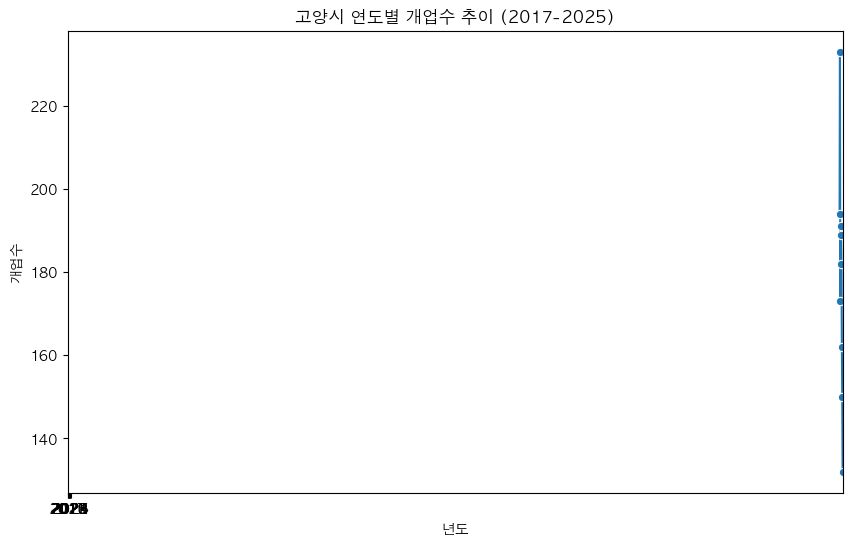

In [45]:
# plot opened_stores 
plt.figure(figsize=(10, 6))
sns.lineplot(data=opened_stores.T, marker='o')
plt.title("고양시 연도별 개업수 추이 (2017-2025)")
plt.xlabel("년도")
plt.ylabel("개업수")
plt.xticks(ticks=range(9), labels=[str(year) for year in range(2017, 2026)])
plt.legend().set_visible(False)  
plt.show()